In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

repo_name = 'cointegrated/rubert-tiny2' #'sberbank-ai/sbert_large_mt_nlu_ru' ## #'###'sberbank-ai/ruSciBERT'

In [2]:
#gpu_devices = tf.config.list_physical_devices('GPU')
#if gpu_devices:
#    print (tf.config.experimental.get_memory_info('GPU:0')['current'])

In [3]:
import pandas as pd
data1 = pd.read_csv ('lemmatized-bestTranslate.csv')
#data1 = pd.read_csv ('cut.csv')
#data1 = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/y/lemmatized-betterParser.csv')

type1 = 'F/T'
if data1.__contains__ ('Unnamed: 0'):
    data1 = data1.drop (columns = ['Unnamed: 0'])
types = ['E/I', 'N/S', 'F/T', 'P/J']
types.remove (type1)
data1 = data1.drop (columns = types)

max_size = data1 [type1].value_counts ().max ()
lst = [data1]
for class_index, group in data1.groupby (type1):
    lst.append (group.sample (max_size - len (group), replace = True))
data1 = pd.concat (lst)

data = data1 ['lemmatized']
labels = data1 [type1]

In [4]:
#newLabels = []
#for label in labels:
#    if label:
#        newLabels.append ([0, 1])
#    else:
#        newLabels.append ([1, 0])
#labels = newLabels
#del newLabels

In [5]:
#%pip install transformers

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained (repo_name)#, force_download = True)

In [7]:
SEQ_LEN = 2000

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(data), SEQ_LEN), dtype = 'int32')
Xmask = np.zeros((len(data), SEQ_LEN), dtype = 'int32')

for i, sentence in enumerate(data):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [8]:
#import tensorflow as tf

BATCH_SIZE = 4  # we will use batches of

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

### del
del Xids
del Xmask
del data1
del data
del labels
del tokenizer
###

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle (11000)

In [9]:


#import tensorflow_datasets as tfds
#dataset = tfds.load ('dataset.tfrecord')

In [10]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])# / 5
#SPLIT = 0.9  # 90-10 split

train_size = int (0.8 * DS_LEN)
val_size = int (0.1 * DS_LEN)

train = dataset.take (train_size)    
val = dataset.skip (train_size).take (val_size)
test = dataset.skip (train_size).skip (val_size).take (val_size)

train = train.cache ()
train = train.shuffle (train_size)
train = train.batch (BATCH_SIZE)
train = train.prefetch (tf.data.AUTOTUNE)

val = val.batch (BATCH_SIZE)
val = val.cache ()
val = val.prefetch (tf.data.AUTOTUNE)

test = test.batch (BATCH_SIZE)
test = test.cache ()
test = test.prefetch (tf.data.AUTOTUNE)

del dataset  # optionally, delete dataset to free up disk-space

In [11]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained(repo_name, from_pt = True)#, force_download = True)

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(64)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
#X = tf.keras.layers.BatchNormalization()(embeddings)
X = tf.keras.layers.Dense(64, activation='relu')(X)
#X = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
#X = tf.keras.layers.Dense(16, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X)
#y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
model.layers[2].trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [12]:
model.summary ()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 2000)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  29193768    ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 2000                                           

In [13]:
#import tensorflow.keras as keras

In [14]:
#gpu_devices = tf.config.list_physical_devices('GPU')
#if gpu_devices:
#    print (tf.config.experimental.get_memory_info('GPU:0')['current'])

In [15]:
#def scheduler(epoch, lr):
#  if epoch < 2:
#    return 0.01
#  elif epoch < 8:
#    return min (lr, 0.001)
#  else:
#    return min (lr, 0.0001)
#
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [16]:
#optimizer = tf.keras.optimizers.Adam(0.0005) #0.001
#loss = tf.keras.losses.BinaryCrossentropy() #tf.keras.losses.CategoricalCrossentropy()   #
#acc = 'accuracy' #tf.keras.metrics.CategoricalAccuracy('accuracy')   #
#
#model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
#h = model.fit(train, validation_data=val, epochs=30)#, callbacks=[callback])
#model.summary()

In [69]:
from transformers import TFBertModel
custom_objects = {"TFBertModel": TFBertModel}
model = tf.keras.models.load_model ('FT.h5', custom_objects, compile = False)
optimizer = tf.keras.optimizers.Adam(0.0005) #0.001
loss = tf.keras.losses.BinaryCrossentropy() #tf.keras.losses.CategoricalCrossentropy()   #
acc = 'accuracy' #tf.keras.metrics.CategoricalAccuracy('accuracy')   #

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [70]:
#figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#
#histx = np.arange(0, len(h.history['loss']), 1)
#ax1.plot(histx, h.history['loss'])
#ax1.set_title("loss")
#
#histx = np.arange(0, len(h.history['accuracy']), 1)
#ax2.plot(histx, h.history['accuracy'])
#ax2.set_title("accuracy")
#
#histx = np.arange(0, len(h.history['val_loss']), 1)
#ax3.plot(histx, h.history['val_loss'])
#ax3.set_title("val_loss")
#
#histx = np.arange(0, len(h.history['val_accuracy']), 1)
#ax4.plot(histx, h.history['val_accuracy'])
#ax4.set_title("val_accuracy")
#
#plt.show ()

235/235 [==============================] - 724s 3s/step
Accuracy:  0.9211087420042644
Precision:  0.8835758835758836
Recall:  0.9593679458239278
F1:  0.9199134199134198


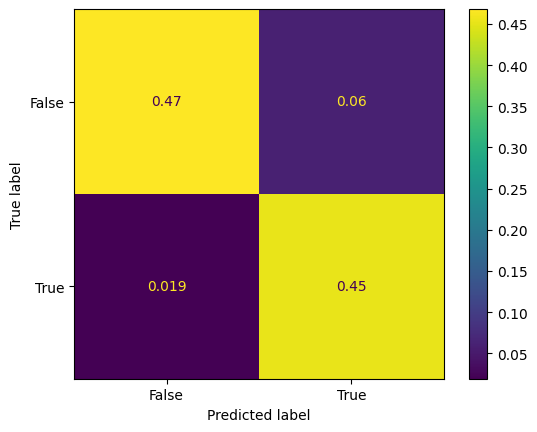

In [71]:
#x = [x for x, y in test.unbatch ()]
y = [y.numpy () for x, y in test.unbatch ()]
threshold = True
categorical = False

prediction = model.predict (test)
if (threshold):
    preds = []
    ny = []
    if (categorical):
        for i in prediction:
            if (i [0] [0] == 1):
                preds.append (False)
            else:
                preds.append (True)
        prediction = preds
        for i in y:
            if (i [0] [0] == 1):
                ny.append (False)
            else:
                ny.append (True)
        y = ny
    else:
        for i in prediction:
            preds.append (i [0] >= 0.5)
        prediction = preds
    del preds
    del ny

print ('Accuracy: ', accuracy_score (y, prediction))
print ('Precision: ', precision_score (y, prediction))
print ('Recall: ', recall_score (y, prediction))
print ('F1: ', f1_score (y, prediction))
ConfusionMatrixDisplay.from_predictions (y, prediction, normalize='all')

In [72]:
#model.save ('PJ.h5')